Imports

In [1]:
# %matplotlib inline
# %config InlineBackend.figure_format = ‘retina’
import math
import matplotlib.pyplot as plt
import os
import random as python_random
import torch
import torch.nn as nn
from torchvision import datasets, transforms
# import helper

Seeding pseudo random numbers

In [2]:
seed = 0
# np.random.seed(seed)
python_random.seed(seed)
# tf.random.set_seed(seed)

Loading covid images dataset

In [8]:
# Reading paths from environment variable
images_path = '/home/sergiosilva/@pessoal/fgv_deep/preprocessed'

# Creating a transformer to "normalize" images
transform = transforms.Compose([
    transforms.RandomRotation(30), # Helping our network generalize
    transforms.Resize(256),
    transforms.CenterCrop(256),
    # transforms.RandomResizedCrop(224), # Helping our network generalize
    transforms.RandomHorizontalFlip(), # Helping our network generalize
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Reading images
dataset = datasets.ImageFolder(images_path, transform=transform)
# dataset_normal = datasets.ImageFolder(normal_path, transform=transforms.ToTensor())

Splitting dataset

In [9]:
train_size = int(len(dataset) * 0.60)
validation_size = int(len(dataset) * 0.15)
test_size = len(dataset) - validation_size - train_size

train_set, validation_set, test_set = torch.utils.data.random_split(dataset, [train_size, validation_size, test_size], generator=torch.Generator().manual_seed(0))

Creating dataloaders

In [10]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

Visualizing a test image

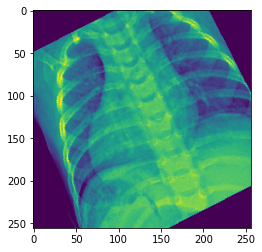

tensor(1)
torch.Size([1, 256, 256])


In [11]:
images, labels = next(iter(train_loader))

img = images[0]
to_pil = transforms.ToPILImage()
img = to_pil(img)
plt.imshow(img)
plt.show(img)
print(labels[0])

print(images[0].shape)

TODO Normalizing images

Creating CNN

In [38]:
num_classes = 2
learning_rate =  0.001

class CNN(nn.Module):
    def __init__(self, num_classes = 2):
        super(CNN,self).__init__()

        # Layer 1
        self.layer1 =  nn.Sequential( 
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2))   

        # num_features = int((math.floor((image_size - kernel_size + 2 * padding_size) / stride_size) + 1) / pooling_size)

        num_features1 = int((1 + (256 - 3 + 2 * 2) / 1)/2)
        print('num_features1', num_features1)

        # Layer 2
        self.layer2 =  nn.Sequential( 
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2))   

        num_features2 = int((1 + (num_features1 - 5 + 2 * 2) / 1)/2)
        print('num_features2', num_features2)

        # Layer 3 - MLP
        self.fc = nn.Linear(num_features2*num_features2*32, num_classes)

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0),-1)
        out = self.fc(out)
        return out

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CNN(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

num_features1 129
num_features2 64


Training the model

In [41]:
num_epochs = 5


list_loss = []
list_time = []
j = 0

total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # forward 
        output = model(images)
        loss   = loss_fn(output, labels)

        # change the params
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        list_loss.append(loss.item())
        list_time.append(j)
        j+=1

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
# Save the model checkpoint
# torch.save(model.state_dict(), 'model.ckpt')     
            
print("Finished Train")           


oi
oi
oi
oi
oi


KeyboardInterrupt: 

Printing training loss

In [ ]:
len(list_loss)
x = [ i for i in range(len(list_loss))]
len(x), len(list_loss)
plt.plot(x,list_loss)

Printing test accuracy

In [ ]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))